# Анализ пользовательского поведения в мобильном приложении
### Цель - анализ поведения пользователей мобильного приложения по результатам А/А/В-теста
### Задачи:
1. выполнить первичную обработку данных: убрать дубликаты, пропуски м др. ;<br>
2. определить границы периода анализа;<br>
3. постоить продуктовые воронки ;<br> 
4. проверить корректность групп статистическими методами и сделать общие выводы.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce
from plotly import graph_objects as go
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

sns.set_palette('dark')

In [3]:
df = pd.read_csv('/datasets/logs_exp.csv' , sep='\t', decimal=',')

### 1. Обработка данных
Проверим данные на наличие дубликатов и пропусков

In [4]:
# переименую названия столбцов, уберу дубликаты, приведу формат данных в столбце event_time в datetime64[ns]
df.columns = ['event', 'user_id', 'event_time', 'group']
df['event_time'] = pd.to_datetime(df['event_time'], unit='s')
df.head(10)

print('количество дубликатов', df.duplicated().sum())
df.drop_duplicates(inplace = True)
df.duplicated().sum()

df.info()

количество дубликатов 413
<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 4 columns):
event         243713 non-null object
user_id       243713 non-null int64
event_time    243713 non-null datetime64[ns]
group         243713 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 9.3+ MB


In [5]:
df['date'] = df['event_time'].dt.date
df.head()

,event,user_id,event_time,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [6]:
# выполню замену названий событий на русский язык, чтобы затем было легче строить воронку
df['event'].unique()

df['event']=df['event'].str.replace('MainScreenAppear', 'зашел на главную страницу')
df['event']=df['event'].str.replace('PaymentScreenSuccessful', 'оплата товара')
df['event']=df['event'].str.replace('CartScreenAppear', 'добавил товар в корзину')
df['event']=df['event'].str.replace('OffersScreenAppear', 'перешел на страницу товара')
df['event']=df['event'].str.replace('Tutoria', 'консультация')

df['event'].unique()

array(['зашел на главную страницу', 'оплата товара',
       'добавил товар в корзину', 'перешел на страницу товара',
       'консультацияl'], dtype=object)

### 2. Изучение данные 
Проверим сколько событий в логе, сколько  пользователей в логе, сколько в среднем событий приходится на пользователя. 

In [7]:
# сгруппируем df по дате, чтобы посмотреть количество событий и уникальных пользователей в сутки
count_event = df.groupby('date').agg({'event': 'count', 'user_id': 'nunique'})
count_event
# рассчитаем среднее количество событий на пользователей
int(df.groupby('user_id')['event'].agg('count').median())

20

In [8]:
# рассчитаем количество уникальных пользователей
count_user = df['user_id'].nunique()
count_user

7551

 Мы узнали, что выборка у нас с 25 июля по 07 августа. И судя по count_event, анализ нужно проводить на данных начиная с 01 августа, так как в предыдущих днях мало событий. <br>
Всего у нас за наблюдаемый период 7551 уникальный пользователь пользователь; событий в дата фрейме - 243713. В среднем, на пользователя приходится 20 событий. 
<br>    
<br>   
Построим гистограмму по дате и времени, чтобы оценить, какими данными мы располагаем

In [ ]:
plt.figure(figsize=(15, 70))
ax = sns.countplot(y = df['event_time'].dt.strftime('%Y-%m-%d %H'), hue='event', data=df, dodge=False)
plt.title('Количество событий')
plt.show()

На графике мы видим то же, что и в count_event, только по часам. В первые дни у нас фактически не было никаких событий, как точку отсчета можно взять 2019-07-31 21 час. На графике можно также визуально оценить распределение данных - оно стремиться к нормальному. 

In [10]:
#отбросим данные, меньше 21 часа 2019-07-31 и проверим функциями min и max правильность вхождения дат
df_filtred = df[df['event_time'] >= '2019-07-31 21']
df_filtred['event_time'].min()
df_filtred['event_time'].max()

df_filtred.head()

,event,user_id,event_time,group,date
1990,зашел на главную страницу,7701922487875823903,2019-07-31 21:00:57,247,2019-07-31
1991,зашел на главную страницу,2539077412200498909,2019-07-31 21:01:45,247,2019-07-31
1992,перешел на страницу товара,3286987355161301427,2019-07-31 21:02:21,248,2019-07-31
1993,перешел на страницу товара,3187166762535343300,2019-07-31 21:02:23,247,2019-07-31
1994,зашел на главную страницу,1118952406011435924,2019-07-31 21:03:25,248,2019-07-31


In [ ]:
df_filtred.info()
df_filtred['user_id'].nunique()
int(df_filtred.groupby('user_id')['event'].agg('count').median())

После фильтрации у нас стало 241 724 события в дата фрейме (вместо 243713, дельта 1989 событий или 0,816%) и 7538 пользователей (вместо 7551, дельта 13 пользователей или 0,17%). 

In [ ]:
plt.figure(figsize=(15, 70))
ax = sns.countplot(y = df_filtred['event_time'].dt.strftime('%Y-%m-%d %H'), hue='group', data=df_filtred)
plt.title('Количество событий')
plt.show()


как мы видим из графика, у нас данные распределены нормально во всех трех группах.    

#### Вывод

В обработке данных удалила дубликаты, переименовала столбцы, добавила столбец с датой. Отбросила не актуальные данные. В df_filtred 241724 событий, 7538 уникальных пользователей  19 событий на каждого пользователя. После фильтрации у нас стало 241 724 события в дата фрейме (вместо 243713, дельта 1989 событий или 0,816%) и 7538 пользователей (вместо 7551, дельта 13 пользователей или 0,17%). 

### 2. Изучение воронки событий
 
Проверим сколько  событий есть в логах, как часто они встречаются,  отсортируем события по частоте.<br>
Посчитаем, сколько пользователей совершали каждое из этих событий. <br>Посчитаем долю пользователей, которые хоть раз совершали событие.


In [8]:
n_users = df_filtred['user_id'].nunique()
n_users

7538

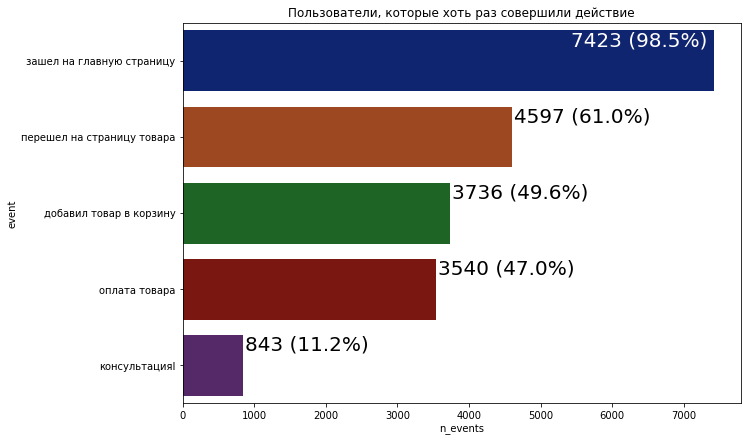

In [9]:
events = df_filtred.groupby('event')['user_id'].agg({'count', 'nunique'}).reset_index()
events.columns = ['event', 'n_events', 'n_users']

events = events.sort_values(by='n_events', ascending=False)
events.head()
plt.figure(figsize=(10, 7))
ax = sns.barplot(x='n_events', y='event', data=events)
plt.title('Пользователи, которые хоть раз совершили действие')

for i in ax.patches:
    if i.get_width() > 7000:
        ax.text(i.get_width()-2000, i.get_y()+0.2, 
                str(int(i.get_width()))+' ({:.1%})'.format(i.get_width() / n_users), fontsize=20, color='white')
                #str(int(i.get_width()) +' ({:.1%})'.format(i.get_width() / n_users), fontsize=20, color='white'))
    else:
        ax.text(i.get_width()+30, i.get_y()+0.2, 
                str(int(i.get_width()))+' ({:.1%})'.format(i.get_width() / n_users), fontsize=20, color='black')
plt.show()

 
98.5% всех пользователей зашли на главную страницу - есть два варианта: они могли случайно перейти по ссылке и быстро звкрыть страницу, или у них некорректно отобразилась страница. Надо проверить.<br>
61.0% всех пользователей перешли на страницу товара - на этом этапе "отпало" 37,5% пользователей - надо проверить отображение страницы на разных типах устройствах, возможно, на каком-то одном типе устройства сайт не работает. <br>
49.5% от всех пользователей добавил товар в корзину и 47,0% оплатили товар - возможно, это вполне хорошие показатели для нашего товара. Мы можем увеличить долю пользователей, завершивших оплату, если найдем причину, по которой от нас уходит 37,5% пользователей.<br>
11,2% пользователей обратились за консультацией и/или поддержкой - жалобы пользователей на сайт -это хороший источник информации о багах, надо его проанализировать. 

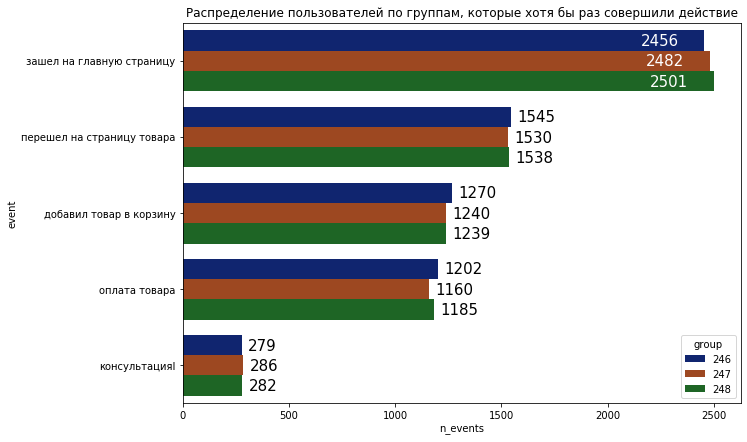

In [10]:
event_pivot = df.groupby(['event','group'])['user_id'].agg({'count', 'nunique'}).reset_index()
event_pivot.columns= ['event','group', 'n_events', 'n_users']
event_pivot = event_pivot.sort_values(by='n_events', ascending=False)

plt.figure(figsize=(10, 7))
ax = sns.barplot(x='n_events', y='event', hue='group', data=event_pivot)
plt.title('Распределение пользователей по группам, которые хотя бы раз совершили действие')

for i in ax.patches:
    if i.get_width() > 2000:
        ax.text(i.get_width()-300, i.get_y()+0.2, 
                str(int(i.get_width())), fontsize=15, color='white')
    else:
        ax.text(i.get_width()+30, i.get_y()+0.2, 
                str(int(i.get_width())), fontsize=15, color='black')
plt.show()



В разрезе по группам визуальное соотношение пользователей на каждом шаге одинаково.

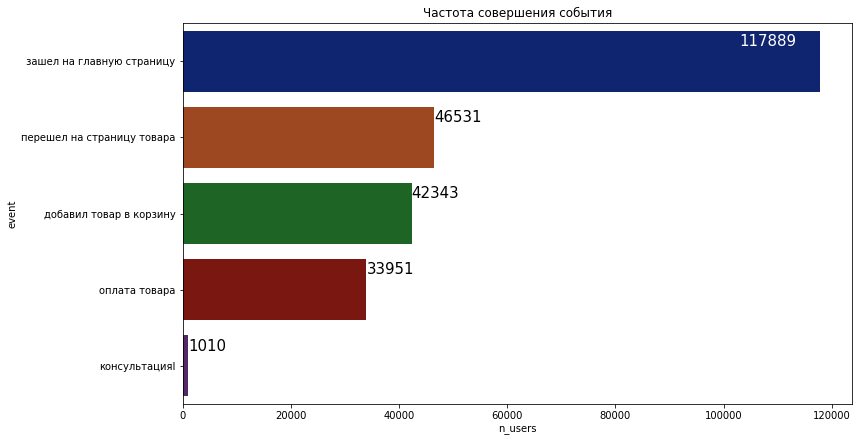

In [11]:

plt.figure(figsize=(12, 7))
ax = sns.barplot(x='n_users', y='event', data=events)
plt.title('Частота совершения события')

for i in ax.patches:
    if i.get_width() > 110000:
        ax.text(i.get_width()-15000, i.get_y()+0.2, 
                str(int(i.get_width())), fontsize=15, color='white')
    else:
        ax.text(i.get_width()+30, i.get_y()+0.2,
               str(int(i.get_width())), fontsize=15, color='black')
plt.show()


За все время наблюдения на сайт зашло почти 118тыс пользователей,<br>
посмотрели товар - 46,5 тыс,<br>
добавили в корзину - 42,3 тыс, <br>
оплатили товар - почти 34 тыс,<br>
обратились в тех поддержку - чуть больше 1 тыс.<br>

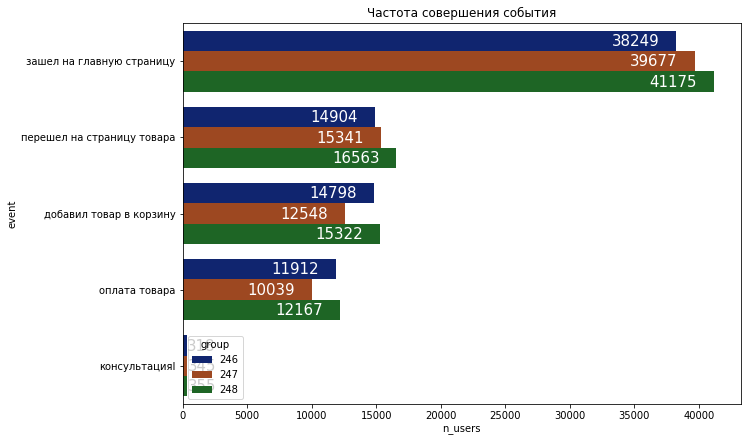

In [12]:
event_pivot = event_pivot.sort_values(by='n_users', ascending=False)

plt.figure(figsize=(10, 7))
ax = sns.barplot(x='n_users', y='event', hue='group', data=event_pivot)
plt.title('Частота совершения события')

for i in ax.patches:
    if i.get_width() > 2500:
        ax.text(i.get_width()-5000, i.get_y()+0.2,
               str(int(i.get_width())), fontsize=15, color='white')
    else:
        ax.text(i.get_width()+30, i.get_y()+0.2,
               str(int(i.get_width())), fontsize=15, color='black')
plt.show()


Наша воронка выглядит следующим образом: <br>
пользователь зашел на сайт<br>
перешел на страницу товара<br>
положил товар в корзину<br>
оплатил товар<br>

In [ ]:
users = df_filtred[df_filtred['event'] != 'консультацияl'].pivot_table(
    index='user_id', columns='event', values='event_time', aggfunc='min'
)
users.head()
 
# тут со временем какая-то ерунда: пользователь 6922444491712477 перешел на страницу товара в 14-19-46, 
# а оплатил в 14-19-40, надо сообщить разработчикам

In [ ]:
step_1 = ~users['зашел на главную страницу'].isna()
step_2 = step_1 & (users['перешел на страницу товара'] > users['зашел на главную страницу'])
step_3 = step_2 & (users['добавил товар в корзину'] > users['перешел на страницу товара'])
step_4 = step_3 & (users['оплата товара'] > users['добавил товар в корзину'])

n_step_1 = users[step_1].shape[0]
n_step_2 = users[step_2].shape[0]
n_step_3 = users[step_3].shape[0]
n_step_4 = users[step_4].shape[0]

print('Посетителей:', n_step_1, '({:.1%})'.format(n_step_1 / n_step_1))
print('Посмотрело товар:', n_step_2, '({:.1%})'.format(n_step_2 / n_step_1))
print('Положили товар в корзину:', n_step_3, '({:.1%})'.format(n_step_3 / n_step_1))
print('Оплатили:', n_step_4, '({:.1%})'.format(n_step_4 / n_step_1))

In [ ]:

fig = go.Figure(
    go.Funnel(
        y=[
            'Посетителей',
            'Посмотрело товар',
            'Положили товар в корзину',
            'Оплатили',
        ],
        x=[n_step_1, n_step_2, n_step_3, n_step_4],
    )
)
fig.show() 

In [ ]:
users = df_filtred[df_filtred['event'] != 'консультацияl'].pivot_table(
        index=['user_id', 'group'], 
        columns='event', 
        values='event_time',
        aggfunc='min').reset_index()

groups = [246, 247, 248]
funnel ={}
for group in groups:
    funnel[group] =[]
    step_1 = (users['group']==group) & (~users['зашел на главную страницу'].isna())
    step_2 = step_1 & (users['перешел на страницу товара'] > users['зашел на главную страницу'])
    step_3 = step_2 & (users['добавил товар в корзину'] > users['перешел на страницу товара'])
    step_4 = step_3 & (users['оплата товара'] > users['добавил товар в корзину'])
    funnel[group].append(users[step_1].shape[0])
    funnel[group].append(users[step_2].shape[0])
    funnel[group].append(users[step_3].shape[0])
    funnel[group].append(users[step_4].shape[0])
    

fig = go.Figure()
for i, group in enumerate(groups):
    fig.add_trace(go.Funnel(
        name = str(group),
        y = [
            'Посетителей',
            'Посмотрело товар',
            'Положили товар в корзину',
            'Оплатили',
        ],
        x = funnel[group]))

fig.show()

#### Вывод

Предполагаемой воронке слудует большинство покупателей, но к концу доходит только 6.2% всех пользователей, которые посетили сайт. При просмотре воронки по группам, в контрольных группах до конца покупки дошли 5.9% пользователей, в опытной группе - 6.7%. Такая небольшая разница дает право предположить, что оформление текта не дает преимущества. 
 <br>Чуть менее половины пользователей - 43,4% уходят от нас после первого попадания на сайт. Это говорит о том, что какая-то версия сайта неудобна и необходимо исправить проблему.<br>

### 2. Изучение результатов эксперимета

Проверим, есть ли статистическая разница между контрольными и опытной группой. Для решения вопроса о пересечении пользователей я применила np.intersect1d,  который возвращает массив уникальных значений, общих для выборок. Пересечений пользователей не обнаружено.

In [11]:
df1 = df_filtred[df_filtred['event'] != 'консультацияl']
gr246 = df1[df1['group'] == 246]['user_id'].unique()
gr247 = df1[df1['group'] == 247]['user_id'].unique()
gr248 =  df1[df1['group'] == 248]['user_id'].unique()

In [12]:
print(np.intersect1d(gr246, gr247))
print(np.intersect1d(gr246, gr248))
print(np.intersect1d(gr247, gr248))

[]
[]
[]


In [13]:
n_users = {'all': df_filtred['user_id'].nunique(), 
           246: df_filtred[df_filtred['group'] == 246]['user_id'].nunique(),
           247: df_filtred[df_filtred['group'] == 247]['user_id'].nunique(),
           248: df_filtred[df_filtred['group'] == 248]['user_id'].nunique()}
#            '246+247': df[(df['group']==246) | (df['group']==247)]['user_id'].nunique()}
n_users

{'all': 7538, 246: 2484, 247: 2517, 248: 2537}


В группе 246 - 2484 пользователя, в 247 - 2517 пользователей, в 248 - 2537 пользователей. 

In [14]:
sample = df_filtred[df_filtred['event'] != 'консультацияl'].pivot_table(index='event', columns='group', values='user_id', aggfunc='nunique').reset_index()
sample = sample.sort_values(by=246, ascending=False)
sample

group,event,246,247,248
1,зашел на главную страницу,2450,2479,2494
3,перешел на страницу товара,1542,1524,1531
0,добавил товар в корзину,1266,1239,1231
2,оплата товара,1200,1158,1182


В выборках отклонение по пользователем немного больше 1%, поэтому их можно сравнивать между собой. 


Применим z_test для контроля А/А групп, а затем сравнения с каждой А группы с В. альфа = 0.05. Нулевая гипотеза: разницы между выборками нет <br>
Альтернативная: разница между выборками есть

In [ ]:
def z_test(first, secend, alpha):
    for i in sample.index:
        alpha= alpha / 3
        z_stat, pval = proportions_ztest([sample[first][i], sample[secend][i]], nobs=[n_users[first], n_users[secend]])
        print(sample['event'][i])
        if pval < alpha:
            print('Отвергаем нулевую гипотезу, есть значимая разница')
        else:
            print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
        

In [ ]:
z_test(246, 247, 0.05)

  
Разницы между контрольными группами нет, можно сравнить каждую А группу с В группой.

In [ ]:
z_test(246, 248, 0.05)

In [ ]:
z_test(247, 248, 0.05)


Разницы между А/А и В группами нет, можно сделать вывод, что изменение шрифта никак не скажется на конверсии. 

### Вывод

1. Воронка сайта выглядит следующим образом: открытие главной страницы, переход на страницу товара, добавление товара в корзину, олата. Предполагаемой воронке слудует большинство покупателей, но к концу доходит только 6.2% всех пользователей, которые посетили сайт.  <br> <br>
2. Исходя из результатов  A/A/B-теста, можно сделать вывод, что  изменение шрифта не оказало значимого эффекта на поведение пользователей. Шрифт можно поменять, можно оставить, пользователи не заметили существенной разницы. Менеджеров больше заинтересует тот факт, что после прихода на страницу почти половина пользователей покидает ее - 43,4%.Это говорит о том, что версия сайта неудобна пользователям, которые заходят с какого-то устройства, и необходимо исправить проблему.
